In [1]:
import h5py
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

from structures_store import h5_load_structure

colors = ['#bf4e30', '#0d3b66', '#0e9595', '#c2c1c2', '#dbad6a']

/home/khaos/miniconda3/envs/pesto/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
uniprots = pd.read_csv("datasets/selected_alphafold_models.csv").query("selected > 0.5")['uniprot'].values

data = {}
with h5py.File("datasets/aggregated_structures_data.h5", 'r') as hf:
    #for uniprot in tqdm(hf.keys()):
    for uniprot in tqdm(uniprots):
        data[uniprot] = h5_load_structure(hf[uniprot])

100%|██████████████████████████████████████| 7464/7464 [00:21<00:00, 351.62it/s]


In [4]:
# subcellular location
locs_dict = json.load(open("datasets/subcellularlocation.json", 'r'))

# go terms
goterms = json.load(open("datasets/goterms.json", 'r'))

# clustered interfaces
multi_interfaces = json.load(open("datasets/clustered_multi_interfaces.json", 'r'))

In [5]:
labels = ["protein", "dna/rna", "ion", "ligand", "lipid"]

sel_tags = [
    'Active site',
    'Binding site',
    'Calcium binding',
    'DNA binding',
    'Glycosylation',
    'Initiator methionine',
    'Intramembrane',
    'Lipidation',
    'Metal binding',
    'Nucleotide binding',
    'Site',
    'Transmembrane',
    'Zinc finger'
]

ss_dict = {
    'H' : "helix",
    'B' : "strand",
    'E' : "strand",
    'G' : "helix",
    'I' : "helix",
    'T' : "coil",
    'S' : "coil",
    ' ' : "coil"
}

In [6]:
annotated_interfaces = []
for uniprot in tqdm(data):
    entry = data[uniprot]
    multi_ints = multi_interfaces[uniprot]
    for itype in multi_ints:
        for ids_int in multi_ints[itype]:
            iids = [np.where(k == np.array(labels))[0].item() for k in itype.split('+')]
            mpi = np.mean(np.min(np.stack([entry[f'p{i}'][ids_int] for i in iids], axis=1), axis=1))
            unotes = np.unique(sum([note.split(':') for note in entry['annotation'][ids_int]], []))
            annotated_interfaces.append({
                'uniprot': uniprot,
                'itype': itype,
                'notes': ':'.join([n for n in unotes if n in sel_tags]),
                'mpi': mpi,
                'size': len(ids_int),
                'ss': ':'.join(np.unique([ss_dict[s] for s in entry['ss'][ids_int]])),
                'mafs': np.mean(entry['afs'][ids_int]),
            })
                
dfi = pd.DataFrame(annotated_interfaces)

100%|██████████████████████████████████████| 7464/7464 [00:10<00:00, 744.97it/s]


In [7]:
# parameters
mp_thr = 0.8
min_size = 5

# high confidence interfaces
dfs = dfi[(dfi['mpi'] > mp_thr) & (dfi['size'] > min_size)]
dfs

,uniprot,itype,notes,mpi,size,ss,mafs
0,Q99497,protein,Lipidation,0.903861,37,coil:helix:strand,98.300000
6,P14174,protein,Active site:Binding site,0.929147,64,coil:helix:strand,98.574218
22,O00244,protein,Metal binding,0.866085,15,coil:helix,98.249334
24,O00244,ion,Metal binding,0.880038,6,coil:helix,97.569998
26,P69905,protein,Site,0.865459,24,coil:helix,98.488750
...,...,...,...,...,...,...,...
118486,Q8TDN2,protein,Glycosylation:Intramembrane:Transmembrane,0.845420,107,coil:helix:strand,90.752337
118490,Q8TDN2,protein,,0.988697,7,helix,79.567142
118497,Q8TDN2,protein+ion,Intramembrane,0.915293,8,coil,94.762500
118511,Q8TDN2,ion,Intramembrane,0.879892,9,coil,94.388889


## Interfaces percentage

In [8]:
dfs['itype'].value_counts()

protein            4084
lipid              2714
ion                1389
ligand              852
dna/rna             562
protein+lipid       474
ion+ligand           91
protein+ion          62
protein+dna/rna      49
dna/rna+ion          41
protein+ligand       32
ion+lipid             9
ligand+lipid          4
Name: itype, dtype: int64

In [9]:
dfs['itype'].value_counts(normalize=True)

protein            0.394094
lipid              0.261893
ion                0.134035
ligand             0.082216
dna/rna            0.054231
protein+lipid      0.045740
ion+ligand         0.008781
protein+ion        0.005983
protein+dna/rna    0.004728
dna/rna+ion        0.003956
protein+ligand     0.003088
ion+lipid          0.000868
ligand+lipid       0.000386
Name: itype, dtype: float64

## Interfaces count

In [10]:
itype_counts = {}
for k, row in dfs.iterrows():
    uniprot, itype = row['uniprot'], row['itype']
    if uniprot in itype_counts:
        if itype in itype_counts[uniprot]:
            itype_counts[uniprot][itype] += 1
        else:
            itype_counts[uniprot][itype] = 1
    else:
        itype_counts[uniprot] = {itype: 1}
        
dfc = pd.DataFrame(itype_counts).T.fillna(0)
dfc

,protein,ion,ligand,lipid,ion+ligand,dna/rna,protein+ligand,protein+ion,protein+dna/rna,dna/rna+ion,protein+lipid,ion+lipid,ligand+lipid
Q99497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P14174,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O00244,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P69905,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P02008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
P10323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q04671,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O14830,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O43278,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


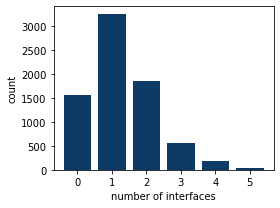

In [11]:
c = np.sum(dfc[labels].values, axis=1)
c = np.bincount(c.astype(int))
c[0] = max(0, dfi['uniprot'].unique().shape[0] - dfc.shape[0])
t = np.arange(6)
c = c[t]

plt.figure(figsize=(4,3))
plt.bar(t, c, color=colors[1])
plt.xlabel('number of interfaces')
plt.ylabel('count')
plt.tight_layout()
plt.show()

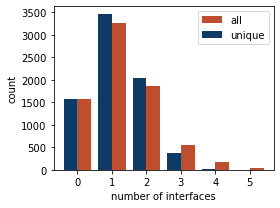

In [12]:
cu = np.sum(np.minimum(dfc[labels].values, 1.0), axis=1)
cu = np.bincount(cu.astype(int))
cu[0] = max(0, dfi['uniprot'].unique().shape[0] - dfc.shape[0])
t = np.arange(6)
cu = cu[t]

plt.figure(figsize=(4,3))
plt.bar(t+0.2, c, width=0.4, color=colors[0], label='all')
plt.bar(t-0.2, cu, width=0.4, color=colors[1], label='unique')
plt.legend(loc='best')
plt.xlabel('number of interfaces')
plt.ylabel('count')
plt.tight_layout()
plt.savefig("results/interfaces_count.png", dpi=300)
plt.savefig("results/interfaces_count.svg")
plt.show()

## Cointerfaces and overlap

In [13]:
cointerfaces = {} 
for i in range(5):
    for j in range(i+1,5):
        i0type = "{}+{}".format(labels[i],labels[j])
        i1type = "{}|{}".format(labels[i],labels[j])
        li = labels[i]
        lj = labels[j]
        
        if i0type in dfc:
            cointerfaces[i0type] = (dfc[i0type] > 0).astype(float)
            cointerfaces[i1type] = ((dfc[li] > dfc[i0type]) & (dfc[lj] > dfc[i0type])).astype(float)
        else:
            cointerfaces[i0type] = 0.0
            cointerfaces[i1type] = ((dfc[li] > 0) & (dfc[lj] > 0)).astype(float)
            
dfco = pd.DataFrame(cointerfaces)

In [14]:
sco = dfco.sum()
sco

protein+dna/rna     46.0
protein|dna/rna    225.0
protein+ion         62.0
protein|ion        481.0
protein+ligand      32.0
protein|ligand     343.0
protein+lipid      462.0
protein|lipid      829.0
dna/rna+ion         38.0
dna/rna|ion         86.0
dna/rna+ligand       0.0
dna/rna|ligand      41.0
dna/rna+lipid        0.0
dna/rna|lipid       74.0
ion+ligand          90.0
ion|ligand          85.0
ion+lipid            9.0
ion|lipid          279.0
ligand+lipid         4.0
ligand|lipid       200.0
dtype: float64

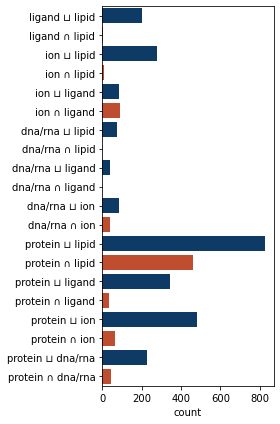

In [15]:
nco = dfco.sum().to_dict()
x = list(nco)
y = list(nco.values())
t = np.arange(len(x))
x = [s.replace('|',' ⊔ ').replace('+', ' ∩ ') for s in x]

plt.figure(figsize=(4,6))
plt.barh(t[::2],y[::2], color=colors[0])
plt.barh(t[1::2],y[1::2], color=colors[1])
plt.yticks(t,x)
plt.ylim(-0.5, len(t)-0.5)
plt.xlabel("count")
plt.tight_layout()
plt.savefig("results/overlapping_interfaces_count.png", dpi=300)
plt.savefig("results/overlapping_interfaces_count.svg")
plt.show()

In [16]:
rco = {}
for i in range(5):
    for j in range(i+1,5):
        i0type = "{}+{}".format(labels[i],labels[j])
        i1type = "{}|{}".format(labels[i],labels[j])
        
        rco[i0type] = sco[i0type] / (sco[i0type] + sco[i1type])
        rco[i1type] = sco[i1type] / (sco[i0type] + sco[i1type])
        
srco = pd.Series(rco)
srco.round(2)

protein+dna/rna    0.17
protein|dna/rna    0.83
protein+ion        0.11
protein|ion        0.89
protein+ligand     0.09
protein|ligand     0.91
protein+lipid      0.36
protein|lipid      0.64
dna/rna+ion        0.31
dna/rna|ion        0.69
dna/rna+ligand     0.00
dna/rna|ligand     1.00
dna/rna+lipid      0.00
dna/rna|lipid      1.00
ion+ligand         0.51
ion|ligand         0.49
ion+lipid          0.03
ion|lipid          0.97
ligand+lipid       0.02
ligand|lipid       0.98
dtype: float64

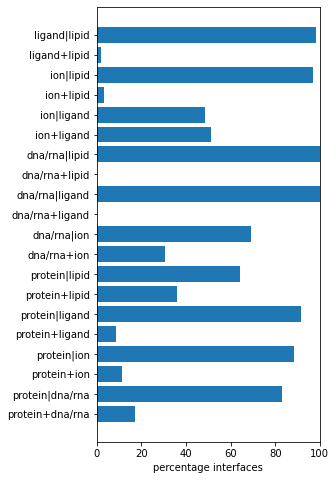

In [17]:
x = list(rco)
y = np.array(list(rco.values()))
t = np.arange(len(x))

plt.figure(figsize=(4,8))
plt.barh(t,y*1e2)
plt.yticks(t,x)
plt.xlim(0.0, 1.0*1e2)
plt.xlabel("percentage interfaces")
plt.show()

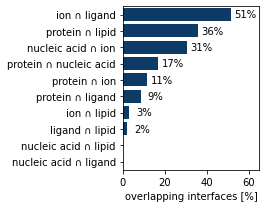

In [35]:
#from theme import colors
colors = ['#bf4e30', '#0d3b66', '#0e9595', '#dbad6a']

x = np.array(list(rco)[::2])
y = np.array(list(rco.values()))
t = np.arange(len(x))

ids_srt = np.argsort(y[::2])
x = x[ids_srt]
x = np.array([v.replace('+', ' ∩ ') for v in x])
x = np.array([v.replace('dna/rna', 'nucleic acid') for v in x])  # quick dirty fix

plt.figure(figsize=(3.8,3))
#plt.barh(t, y[1::2][ids_srt]*1e2, label='non-overlapping', color=colors[0])
#plt.barh(t, y[::2][ids_srt]*1e2, left=1e2*y[1::2][ids_srt], label='overlapping', color=colors[1])
plt.barh(t, y[::2][ids_srt]*1e2, color=colors[1])
for k, v in enumerate(y[::2][ids_srt]*1e2):
    if v > 1:
        plt.text(v+7.0, k, '{:.0f}%'.format(v), horizontalalignment='center', verticalalignment='center')
plt.yticks(t,x)
plt.xlim(0.0, 0.65*1e2)
plt.ylim(-0.5, len(t)-0.5)
plt.xlabel("overlapping interfaces [%]")
#plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig("results/overlapping_interfaces_ratio.png", dpi=300)
plt.savefig("results/overlapping_interfaces_ratio.svg")
plt.show()

## Inconsistent annotation

In [19]:
dfsa = dfs[dfs['notes'] != '']
dfsa

,uniprot,itype,notes,mpi,size,ss,mafs
0,Q99497,protein,Lipidation,0.903861,37,coil:helix:strand,98.300000
6,P14174,protein,Active site:Binding site,0.929147,64,coil:helix:strand,98.574218
22,O00244,protein,Metal binding,0.866085,15,coil:helix,98.249334
24,O00244,ion,Metal binding,0.880038,6,coil:helix,97.569998
26,P69905,protein,Site,0.865459,24,coil:helix,98.488750
...,...,...,...,...,...,...,...
118466,O14830,ion,Calcium binding,0.956778,20,coil:helix:strand,83.287999
118486,Q8TDN2,protein,Glycosylation:Intramembrane:Transmembrane,0.845420,107,coil:helix:strand,90.752337
118497,Q8TDN2,protein+ion,Intramembrane,0.915293,8,coil,94.762500
118511,Q8TDN2,ion,Intramembrane,0.879892,9,coil,94.388889


In [20]:
N0 = dfs['uniprot'].unique().shape[0]
Na = dfsa['uniprot'].unique().shape[0]
"{} / {} = {:.1f}%".format(Na, N0, 1e2*Na/N0)

'3645 / 5894 = 61.8%'

In [21]:
expected_annotations = {
    "protein": [],
    "dna/rna": ['DNA binding', 'Nucleotide binding', 'Zinc finger'],
    "ion": ['Active site', 'Binding site', 'Calcium binding', 'Metal binding', 'Zinc finger', 'Site'],
    "ligand": ['Binding site', 'Site', 'Nucleotide binding'],
    "lipid": ['Transmembrane', 'Intramembrane', 'Lipidation'],
}

sel = []
for k, row in dfsa.iterrows():
    notes = row['notes'].split(':')
    itype = row['itype']
    
    if '+' not in itype:
        sel.append(np.any([note not in expected_annotations[itype] for note in notes]))
    else:
        sel.append(False)

In [22]:
dfw = dfsa[np.array(sel)]
dfw

,uniprot,itype,notes,mpi,size,ss,mafs
0,Q99497,protein,Lipidation,0.903861,37,coil:helix:strand,98.300000
6,P14174,protein,Active site:Binding site,0.929147,64,coil:helix:strand,98.574218
22,O00244,protein,Metal binding,0.866085,15,coil:helix,98.249334
26,P69905,protein,Site,0.865459,24,coil:helix,98.488750
32,P69905,ligand,Glycosylation:Metal binding:Site,0.885182,36,coil:helix,98.484444
...,...,...,...,...,...,...,...
118418,Q04671,protein,Glycosylation,0.847218,17,coil:strand,79.911176
118456,O14830,protein,Calcium binding,0.872490,11,coil:helix,77.672727
118486,Q8TDN2,protein,Glycosylation:Intramembrane:Transmembrane,0.845420,107,coil:helix:strand,90.752337
118511,Q8TDN2,ion,Intramembrane,0.879892,9,coil,94.388889


In [23]:
Na = dfsa['uniprot'].unique().shape[0]
Nw = dfw['uniprot'].unique().shape[0]
"{} / {} = {:.1f}%".format(Nw, Na, 1e2*Nw/Na)

'2151 / 3645 = 59.0%'

In [24]:
wrong_counts = {}
for k, row in dfsa.iterrows():
    itype = row['itype']
    notes = row['notes'].split(':')
    if '+' not in itype:
        for note in notes:
            if note not in expected_annotations[itype]:
                if itype in wrong_counts:
                    if note in wrong_counts[itype]:
                        wrong_counts[itype][note] += 1
                    else:
                        wrong_counts[itype][note] = 1
                else:
                    wrong_counts[itype] = {note:1}
            
dfwc = pd.DataFrame(wrong_counts)
dfwc

,protein,ligand,ion,dna/rna,lipid
Lipidation,27,NaN,2.0,1.0,NaN
Active site,117,92.0,NaN,27.0,36.0
Binding site,183,NaN,NaN,26.0,55.0
Metal binding,107,138.0,NaN,30.0,49.0
Site,70,NaN,NaN,19.0,61.0
Nucleotide binding,145,NaN,95.0,NaN,15.0
Calcium binding,48,NaN,NaN,NaN,8.0
Transmembrane,951,53.0,123.0,14.0,NaN
Glycosylation,166,35.0,30.0,11.0,122.0
DNA binding,7,NaN,3.0,NaN,NaN
